In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import loadmat
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
import import_ipynb
try:
    os.chdir('C:\\Users\\hydro_leo\\Documents\\GitHub\\retina_python\\Modules')
except:
    os.chdir('Modules')
# from Spike_Generation import SG
from Spike_Generation import Spike_Time_Generater
from Spike_Generation import NL

importing Jupyter notebook from Spike_Generation.ipynb


# Ganerate Spike from FBFF model (Poison)

## k_E and k_S

In [4]:
def NGD_TK(T, m, n, alpha, beta, g, tau_y):
    dt = np.mean(np.diff(T))
    dt = dt/50
    T = np.arange(0, T[-1]+dt, dt)
    x = T/tau_y /tau_y *np.exp(-T/tau_y)*dt
    y = np.zeros_like(x)
    z = np.zeros_like(x)
    
    for i in range(len(T)):
        y[i] = y[i-1] + dt*(-alpha*y[i-1]+m*x[i-1]-n*z[i-1])
        z[i] = z[i-1] + dt*( -beta*z[i-1]+g*y[i-1])
    return y[:len(T):50], z[:len(T):50]

In [5]:
m = 4.037925
n =	100
alpha = 8.351984
beta = 3.123359
g =  442.699730/n
tau_y = 0.050404

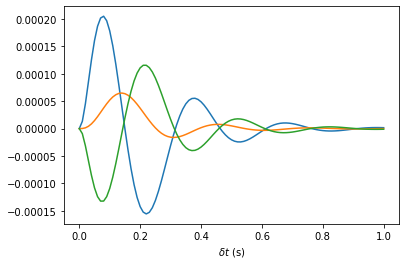

In [6]:
dt = 0.01
TKaxis = np.arange(101)*dt

psi = 0.3
k_E, k_S = NGD_TK(TKaxis, m, n, alpha, beta, g, tau_y)
# y_TK, w_TK = NGD_TK(TKaxis, *[2.67758918, 1.00000000, 1.17089092e+01, 4.69398540, 4.73653606e+02, 2.45547756e-02])
plt.plot(TKaxis, k_E)
plt.plot(TKaxis, k_S)
plt.xlabel(r'$\delta t$ (s)')
plt.plot(TKaxis, -(k_E*(1-psi)-k_S*psi))

## Load and Check Input

In [7]:
dt = 0.01

annots = loadmat('D:\\GoogleDrive\\retina\\Exps\\2021\\1103\\SplitData\\diode_repeat_OU_tau=500ms_cutoff=1_mean=10_C=0.2_03-Nov-2021_0', squeeze_me = True)
sampling_rate = 20000
TimeStamps = annots['TimeStamps']
x = annots['a_data'][0, int(TimeStamps[0]*sampling_rate):int(TimeStamps[1]*sampling_rate)+1]
x = x[::int(sampling_rate*dt)]
x = x.astype(float)
x = (x-np.mean(x))/np.std(x)
T = np.arange(len(x))*dt

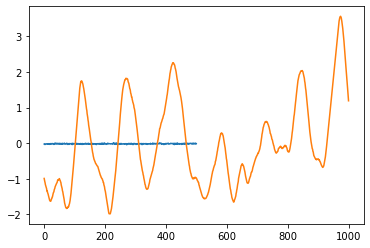

In [8]:
restTime = 5
stiTime = 10
trial = 20

plt.plot(x[:int(restTime/dt)])
plt.plot(x[int(restTime/dt):int((restTime+stiTime)/dt)])

xOri = x.copy()
x = x[int(restTime/dt):int((restTime+stiTime)/dt)]

In [9]:
amp = 2
mean = 10

psi = 0.3

apapt_step = int(1/dt)
eOutput = np.convolve( np.hstack((np.ones(apapt_step)*mean,x*amp+mean)), k_E, 'full')[apapt_step:apapt_step+len(x)]
sOutput = np.convolve( np.hstack((np.ones(apapt_step)*mean,x*amp+mean)), k_S, 'full')[apapt_step:apapt_step+len(x)]
output = -(eOutput*(1-psi)-sOutput*psi)

## Subtraction + GC (Gain act on both)

In [10]:
#Gain control function
def gain_func(v):
    try: # if v is an ndarray
        v[v < 0] = 0
    except: # if v is a variable
        if v < 0 : return 1
    return 1/(1+v**4)
    
def AddGainControl(r, B, tau):
    decay = np.exp(-(np.arange(0,1,dt)+dt)/tau)
    # plt.plot(np.arange(0,1,dt)+dt,decay)

    output = np.zeros_like(r)
    gain = np.zeros_like(r)
    for i in np.arange(1,r.shape[0]):
        gain[i] = gain_func(np.sum(B*decay[:min(i,len(decay))]*output[i:max(0, i-len(decay)):-1]*dt) )
        opi = gain[i]*r[i]
        output[i] = opi
    output[output<0] = 0
    return  output, gain

In [11]:
B_e = 3000 #To tune altitude of gain control (D=1/T)
tau_e = 0.1

B_s = 245.0 #To tune altitude of gain control (D=1/T)
tau_s = 0.6

Mean_list = [1,4,7,10,13]
Contrast_list = [0.05,0.1,0.2,0.3]
Data2DList = [[ {} for c in Contrast_list] for m in Mean_list]

for mi in range(len(Mean_list)):
    for ci in range(len(Contrast_list)):
        eOutput = np.convolve( np.hstack((np.ones(apapt_step)*Mean_list[mi],(x*Contrast_list[ci]+1)*Mean_list[mi])), k_E, 'full')[:apapt_step+len(x)]
        sOutput = np.convolve( np.hstack((np.ones(apapt_step)*Mean_list[mi],(x*Contrast_list[ci]+1)*Mean_list[mi])), k_S, 'full')[:apapt_step+len(x)]
        eOutput, _ = AddGainControl(eOutput, B_e, tau_e)    
        sOutput, _ = AddGainControl(sOutput, B_s, tau_s)

        Data2DList[mi][ci]['output'] = -eOutput[apapt_step:]*(1-psi)+sOutput[apapt_step:]*psi
    

# Information (R_info)

In [12]:
def R_info(rstate_trial, binnum, overlap = False):
    rstate_trial = np.array(rstate_trial)
    wordsCollection = []
    for rstate in rstate_trial:
        rstate[rstate>1] = 1
        if overlap:
            for i in np.arange(0,len(rstate)-binnum+1):
                wordsCollection.append(rstate[i:i+binnum])
        else:
            for i in np.arange(0,len(rstate)-binnum+1,binnum):
                wordsCollection.append(rstate[i:i+binnum])
    _, index = np.unique(np.array(wordsCollection), axis = 0, return_inverse=True)
    N, _ = np.histogram(index,bins=np.append(np.unique(index),max(index)))
    P = N/np.sum(N)
    totalEntropy = -np.sum(P*np.log2(P))

    trial_num = rstate_trial.shape[0]
    event_num = int(len(wordsCollection)/rstate_trial.shape[0])

    subEntropy = 0
    for i in range(event_num):
        subSet = []
        for j in range(trial_num):
            subSet.append(wordsCollection[event_num*j+i])
        _, index = np.unique(np.array(subSet), axis = 0, return_inverse=True)
        N, _ = np.histogram(index,bins=np.append(np.unique(index),max(index)))
        P = N/np.sum(N)
        subEntropy += -np.sum(P*np.log2(P))
    
    noiseEntropy = subEntropy/event_num
    return totalEntropy, noiseEntropy


In [13]:
binLen = dt/10
binNum = 10

In [14]:
for mi in range(len(Mean_list)):
    for ci in range(len(Contrast_list)):
        r = Data2DList[mi][ci]['output']

        rstate_Trial = [0]*trial
        Spike_Trial = [0]*trial
        for ti in range(trial):
            Spike_Trial[ti] = Spike_Time_Generater( NL(r,np.mean(r)), dt, 10, 10)
            rstate_Trial[ti], _ = np.histogram(Spike_Trial[ti], np.arange(int(restTime/binLen)+1)*binLen)
        totalEntropy, noiseEntropy = R_info(rstate_Trial, binNum)

        Data2DList[mi][ci]['Spike_Trial'] = Spike_Trial
        Data2DList[mi][ci]['totalEntropy'] = np.array(totalEntropy)
        Data2DList[mi][ci]['noiseEntropy'] = np.array(noiseEntropy)

Text(0, 0.5, 'information (bit)')

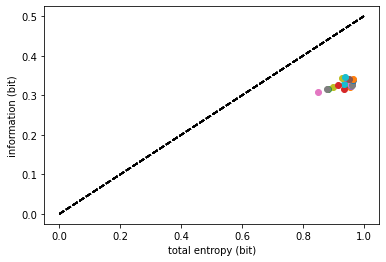

In [15]:
for data in np.array(Data2DList).flatten():
    totalEntropy = data['totalEntropy']
    noiseEntropy = data['noiseEntropy']
    plt.scatter(totalEntropy,totalEntropy-noiseEntropy)
    plt.plot([0, 1.], [0, 0.5], 'k--')
plt.xlabel('total entropy (bit)')
plt.ylabel('information (bit)')

## DCCM

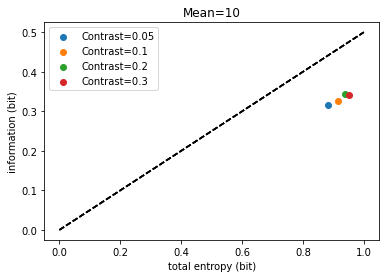

In [16]:
mi = 3
for ci in range(len(Contrast_list)):
    totalEntropy = Data2DList[mi][ci]['totalEntropy']
    noiseEntropy = Data2DList[mi][ci]['noiseEntropy']
    plt.scatter(totalEntropy,totalEntropy-noiseEntropy, label = 'Contrast='+str(Contrast_list[ci]))
    plt.plot([0, 1.], [0, 0.5], 'k--')
plt.xlabel('total entropy (bit)')
plt.ylabel('information (bit)')
plt.title('Mean='+str(Mean_list[mi]))
plt.legend()

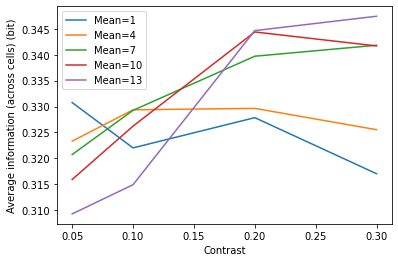

In [17]:
for mi in range(len(Mean_list)):
    mean_totalEntropy = np.zeros(len(Contrast_list))
    mean_noiseEntropy = np.zeros(len(Contrast_list))
    for ci in range(len(Contrast_list)):
        mean_totalEntropy[ci] = np.mean(np.array(Data2DList[mi][ci]['totalEntropy']))
        mean_noiseEntropy[ci] = np.mean(np.array(Data2DList[mi][ci]['noiseEntropy']))
    # plt.plot(Contrast_list,mean_totalEntropy, label = 'Mean='+str(Mean_list[mi]))
    plt.plot(Contrast_list, mean_totalEntropy-mean_noiseEntropy, label = 'Mean='+str(Mean_list[mi]))
    # plt.plot(Contrast_list, (mean_totalEntropy-mean_noiseEntropy)/mean_totalEntropy , label = 'Mean='+str(Mean_list[mi]))
plt.xlabel('Contrast')
plt.ylabel('Average information (across cells) (bit)')
plt.legend()

## CCDM

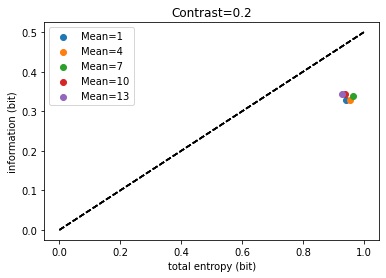

In [18]:
ci = 2
for mi in range(len(Mean_list)):
    totalEntropy = Data2DList[mi][ci]['totalEntropy']
    noiseEntropy = Data2DList[mi][ci]['noiseEntropy']
    plt.scatter(totalEntropy,totalEntropy-noiseEntropy, label = 'Mean='+str(Mean_list[mi]))
    plt.plot([0, 1.], [0, 0.5], 'k--')
plt.xlabel('total entropy (bit)')
plt.ylabel('information (bit)')
plt.title('Contrast='+str(Contrast_list[ci]))
plt.legend()

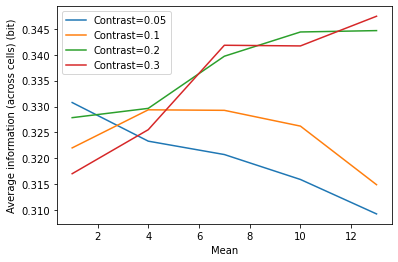

In [19]:
for ci in range(len(Contrast_list)):
    mean_totalEntropy = np.zeros(len(Mean_list))
    mean_noiseEntropy = np.zeros(len(Mean_list))
    for mi in range(len(Mean_list)):
        mean_totalEntropy[mi] = np.mean(np.array(Data2DList[mi][ci]['totalEntropy']))
        mean_noiseEntropy[mi] = np.mean(np.array(Data2DList[mi][ci]['noiseEntropy']))
    # plt.plot(Mean_list,mean_totalEntropy, label = 'Contrast='+str(Contrast_list[ci]))
    plt.plot(Mean_list, mean_totalEntropy-mean_noiseEntropy, label = 'Contrast='+str(Contrast_list[ci]))
    # plt.plot(Mean_list, (mean_totalEntropy-mean_noiseEntropy)/mean_totalEntropy , label = 'Contrast='+str(Contrast_list[ci]))
plt.xlabel('Mean')
plt.ylabel('Average information (across cells) (bit)')
plt.legend()

# test differet firing rate and $\kappa$

Text(0, 0.5, 'information (bit)')

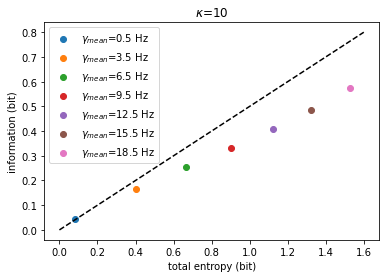

In [27]:
mi = 3
ci = 2
r = Data2DList[mi][ci]['output']

Gamma = 10
for firingRate in np.arange(0.5,20,3):
    Spike_Trial = [0]*trial
    rstate_Trial = [0]*trial
    for ti in range(trial):
        Spike_Trial[ti] = Spike_Time_Generater( NL(r,np.mean(r)), dt, firingRate, Gamma)
        rstate_Trial[ti], _ = np.histogram(Spike_Trial[ti], np.arange(int(restTime/binLen)+1)*binLen)

    totalEntropy, noiseEntropy = R_info(rstate_Trial, binNum) 
    plt.scatter(totalEntropy, totalEntropy-noiseEntropy, label = r'$\gamma_{mean}$='+str(firingRate)+' Hz')
plt.plot([0, 1.6], [0, 0.8], 'k--')
plt.legend(loc = 'best')
plt.title(r'$\kappa$='+str(Gamma))
plt.xlabel('total entropy (bit)')
plt.ylabel('information (bit)')

Text(0, 0.5, 'information (bit)')

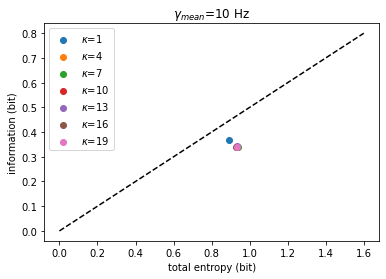

In [28]:
mi = 3
ci = 2
r = Data2DList[mi][ci]['output']

firingRate = 10
for Gamma in np.arange(1,20,3):
    Spike_Trial = [0]*trial
    rstate_Trial = [0]*trial
    for ti in range(trial):
        Spike_Trial[ti] = Spike_Time_Generater( NL(r,np.mean(r)), dt, firingRate, Gamma)
        rstate_Trial[ti], _ = np.histogram(Spike_Trial[ti], np.arange(int(restTime/binLen)+1)*binLen)

    totalEntropy, noiseEntropy = R_info(rstate_Trial, binNum)
    plt.scatter(totalEntropy, totalEntropy-noiseEntropy, label = r'$\kappa$='+str(Gamma))
plt.plot([0, 1.6], [0, 0.8], 'k--')
plt.legend(loc = 'best')
plt.title(r'$\gamma_{mean}$='+str(firingRate)+' Hz')
plt.xlabel('total entropy (bit)')
plt.ylabel('information (bit)')

# Spike Event Plot

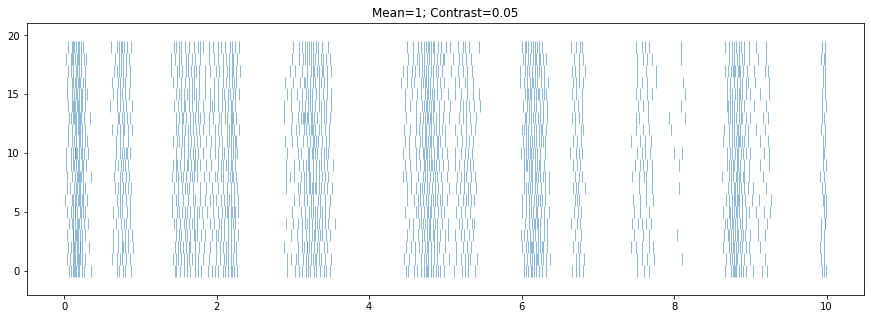

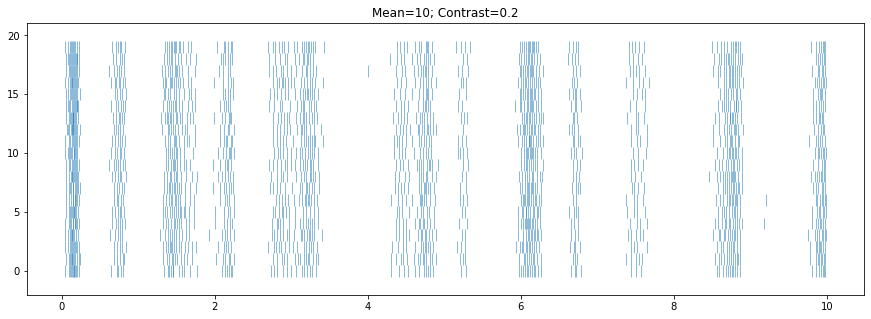

In [21]:
fig, ax = plt.subplots()
mi = 0
ci = 0
ax.eventplot(Data2DList[mi][ci]['Spike_Trial'], linewidths=0.5)
ax.set_title('Mean='+str(Mean_list[mi])+'; Contrast='+str(Contrast_list[ci]))
fig.set_size_inches(15, 5)

fig, ax = plt.subplots()
mi = 3
ci = 2
ax.eventplot(Data2DList[mi][ci]['Spike_Trial'], linewidths=0.5)
ax.set_title('Mean='+str(Mean_list[mi])+'; Contrast='+str(Contrast_list[ci]))
fig.set_size_inches(15, 5)

# varify Poison with variance-mean

[0 1 2 3 4]
[0 1 2 3 4]
[0 1 2 3 4]
[0 1 2 3]
[0 1 2 3 4]
[0 1 2 3 4]
[0 1 2 3 4]
[0 1 2 3 4]
[0 1 2 3 4]
[0 1 2 3 4 5]
[0 1 2 3 4 5]
[0 1 2 3 4]
[0 1 2 3 4 5]
[0 1 2 3 4 5]
[0 1 2 3 4 5]
[0 1 2 3 4]
[0 1 2 3 4 5]
[0 1 2 3 4]
[0 1 2 3 4 5 6]
[0 1 2 3 4 5 6]


Text(0.5, 1.0, 'stimulus: LPOU')

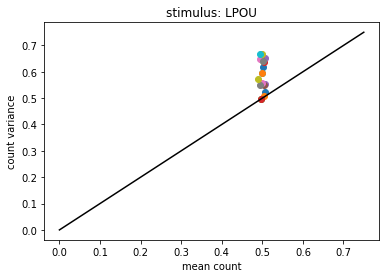

In [22]:
winSize = 0.05 # dt = 0.01
for mi in range(len(Mean_list)):
    for ci in range(len(Contrast_list)):
        Spike_Trial = Data2DList[mi][ci]['Spike_Trial']

        rstate_Trial = [0]*trial
        for ti in range(trial):
            rstate_Trial[ti], _ = np.histogram(Spike_Trial[ti], np.arange(int(stiTime/winSize)+1)*winSize)

        print(np.unique(np.array(rstate_Trial).flatten()))
        plt.scatter( np.mean(np.array(rstate_Trial).flatten()), np.var(np.array(rstate_Trial).flatten()))

plt.plot([0, 15*binLen], [0, 15*binLen], 'k')
plt.xlabel('mean count')
plt.ylabel('count variance')
plt.title('stimulus: LPOU')

Text(0.5, 1.0, 'stimulus: LPOU')

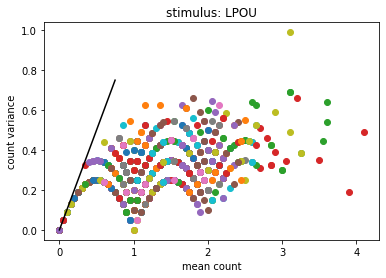

In [23]:
winSize = 0.05 # dt = 0.01
for mi in range(len(Mean_list)):
    for ci in range(len(Contrast_list)):
        Spike_Trial = Data2DList[mi][ci]['Spike_Trial']

        rstate_Trial = [0]*trial
        for ti in range(trial):
            rstate_Trial[ti], _ = np.histogram(Spike_Trial[ti], np.arange(int(stiTime/winSize)+1)*winSize)
        for i in range(len(rstate_Trial[ti])):
            plt.scatter( np.mean(np.array(rstate_Trial)[:,i]), np.var(np.array(rstate_Trial)[:,i]))

plt.plot([0, 15*binLen], [0, 15*binLen], 'k')
plt.xlabel('mean count')
plt.ylabel('count variance')
plt.title('stimulus: LPOU')

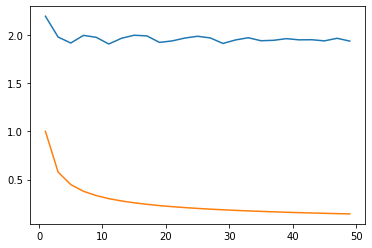

In [24]:
mi = 3
ci = 2
r = Data2DList[mi][ci]['output']

ISI_CV = []
Gamma_list = np.arange(1,50,2)
for Gamma in Gamma_list:
    Spike = Spike_Time_Generater( NL(r,np.mean(r)), dt, 10, Gamma)
    ISI = np.diff(Spike)
    ISI_CV.append(np.std(ISI)/np.mean(ISI))

plt.plot(Gamma_list, ISI_CV)
plt.plot(Gamma_list, 1/np.sqrt(Gamma_list))